In [1]:
import torch.nn.functional as F
import torch
import numpy as np
import torch.nn as nn

In [2]:
embed_size = 300
batch_size = 16
seq_lenght = 20

## Standard Self Attention

$$
y_{i} = \sum w_{ij}*x_{i}
$$

$$
w_{ij}'=x_{i}*x_{j}^\intercal
$$

$$
w_{ij}=\frac{\exp{w_{ij}'}}{\sum_{j}\exp{w_{ij}'}}
$$

In [4]:
x = torch.rand(batch_size, seq_lenght, embed_size)
x.shape

torch.Size([16, 20, 300])

In [5]:
raw_w = torch.bmm(x,x.transpose(1,2))
raw_w.shape

torch.Size([16, 20, 20])

In [6]:
w = F.softmax(raw_w, dim=2)
w.shape

torch.Size([16, 20, 20])

In [7]:
y = torch.bmm(w,x)
y.shape

torch.Size([16, 20, 300])

In [9]:
def raw_self_attn(x):
    raw_w = torch.bmm(x,x.transpose(1,2))
    w = F.softmax(raw_w, dim=2)
    y = torch.bmm(w,x)
    return y, w

In [10]:
out, att_m = raw_self_attn(x)

In [11]:
out.shape

torch.Size([16, 20, 300])

In [18]:
att_m

tensor([[[1.0000e+00, 2.0045e-10, 7.7414e-08,  ..., 1.3308e-07,
          1.1775e-09, 1.8701e-09],
         [2.7884e-14, 1.0000e+00, 8.3759e-11,  ..., 6.3188e-11,
          1.1942e-12, 7.6295e-14],
         [2.4892e-14, 1.9362e-13, 1.0000e+00,  ..., 6.5164e-11,
          1.2360e-13, 2.7220e-14],
         ...,
         [4.8135e-14, 1.6430e-13, 7.3300e-11,  ..., 1.0000e+00,
          9.3402e-13, 8.6465e-14],
         [2.0050e-12, 1.4618e-11, 6.5451e-10,  ..., 4.3969e-09,
          1.0000e+00, 4.5316e-11],
         [8.2453e-11, 2.4182e-11, 3.7324e-09,  ..., 1.0540e-08,
          1.1734e-09, 1.0000e+00]],

        [[1.0000e+00, 1.0405e-12, 7.9192e-12,  ..., 1.1345e-11,
          1.1226e-11, 3.1299e-10],
         [6.2483e-10, 1.0000e+00, 2.5145e-10,  ..., 1.8332e-12,
          2.8901e-11, 1.1827e-09],
         [3.3825e-11, 1.7885e-12, 1.0000e+00,  ..., 3.2056e-13,
          1.0353e-12, 2.1346e-10],
         ...,
         [3.7643e-10, 1.0129e-13, 2.4902e-12,  ..., 1.0000e+00,
          7.491

In [13]:
from matplotlib.pyplot import imshow

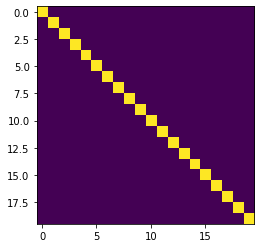

In [14]:
imshow(att_m[0])

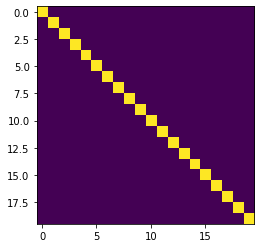

In [15]:
imshow(att_m[-1])

## Benefits of Self Attention
- Best of both worlds (CNNs and RNNs)
    - work with long sequences inputs (RNNs)
    - paralelization (CNNs)

In [ ]:
x = torch.rand(batch_size, seq_lenght, embed_size)
x

In [ ]:
raw_w = torch.bmm(x,x.transpose(1,2))
w = F.softmax(raw_w, dim=2)

In [ ]:
w[0]

# Improvements
- Scaled Self Attention
- Queries, Keys, Values
- Multi-Head Attention

### 1. Scaled Self Attention

In [19]:
raw_w = torch.bmm(x,x.transpose(1,2))
print(raw_w.mean())
raw_w = raw_w/ np.sqrt(embed_size)
raw_w.mean()

tensor(75.7632)


tensor(4.3742)

In [20]:
np.sqrt(embed_size)

17.320508075688775

In [21]:
def scaled_self_attn(x):
    batch_size, seq_lengt, embed_size = x.size()
    raw_w = torch.bmm(x,x.transpose(1,2))
    raw_w = raw_w/ np.sqrt(embed_size)
    w = F.softmax(raw_w, dim=2)
    y = torch.bmm(w,x)
    return y, w

In [22]:
y0,w0 = raw_self_attn(x)
w0.mean()

tensor(0.0500)

In [23]:
y1,w1 = scaled_self_attn(x)
w1.mean()

tensor(0.0500)

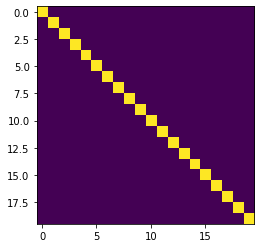

In [24]:
imshow(w0[0])

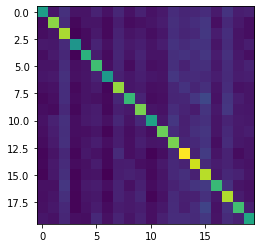

In [25]:
imshow(w1[0])

### 2. Queries, Keys, Values
- Attention is a soft dictionary
- Every key matches a query to some extend
- Not return a specific value, but a mixture of values (with softmax normalized dot products as a mixture of weights)
- In self attention, all keys, queries and values comes from the same set

In [26]:
class SingleHeadSelfAttn(nn.Module):
    def __init__(self, seq_lenght, embed_size, return_attention = False):
        super().__init__()
        self.lenght = seq_lenght
        self.embed = embed_size
        self.return_w = return_attention
        self.transform_q = nn.Linear(self.embed, self.embed)
        self.transform_k = nn.Linear(self.embed, self.embed)
        self.transform_v = nn.Linear(self.embed, self.embed)
        return None
    
    def scaled_dot_attention(self, q, k, v):
        raw_w = torch.bmm(q,k.transpose(1,2))
        raw_w = raw_w/ np.sqrt(self.embed)
        w = F.softmax(raw_w, dim=2)
        out = torch.bmm(w, v)
        if self.return_w:
            return out, w.detach().numpy()
        else:
            return out
    
    def forward(self, x):
        q = self.transform_q(x)
        k = self.transform_k(x)
        v = self.transform_v(x)
        out = self.scaled_dot_attention(q,k,v)
        return out

In [27]:
seq_lenght, embed_size

(20, 300)

In [28]:
x.shape

torch.Size([16, 20, 300])

In [29]:
att = SingleHeadSelfAttn(seq_lenght, embed_size, return_attention=True)

In [30]:
outs, w = att(x)
outs.shape, w.shape

(torch.Size([16, 20, 300]), (16, 20, 20))

In [31]:
w[0]

array([[0.05294493, 0.04797028, 0.05228442, 0.05048753, 0.05051535,
        0.05176257, 0.04710874, 0.04480923, 0.04823131, 0.04902227,
        0.04751909, 0.04619498, 0.05433052, 0.0474708 , 0.05104551,
        0.05373199, 0.05243361, 0.04824755, 0.04944122, 0.05444816],
       [0.05147185, 0.04886695, 0.05337277, 0.05394008, 0.05102687,
        0.05158846, 0.04635799, 0.04611656, 0.04731797, 0.04819224,
        0.04747458, 0.04662602, 0.05438085, 0.04620897, 0.04955987,
        0.05259199, 0.05024915, 0.05165584, 0.05064415, 0.05235688],
       [0.05261984, 0.05076938, 0.05274709, 0.05299453, 0.04946551,
        0.05038333, 0.04898863, 0.04460839, 0.04617782, 0.04759924,
        0.04913336, 0.04440113, 0.05628961, 0.04656982, 0.04956175,
        0.05219776, 0.05335011, 0.05057373, 0.05055245, 0.05101646],
       [0.05356193, 0.04775684, 0.05358396, 0.05126304, 0.05135076,
        0.05198791, 0.04613065, 0.0467647 , 0.04768611, 0.04876988,
        0.04718163, 0.04768127, 0.05413708, 0

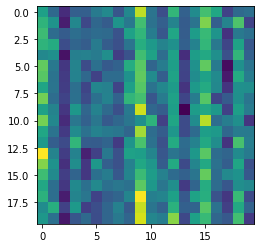

In [33]:
imshow(w[2])